# Домашнее задание № 32
#### Козел А.Г.
28.03.2023-30.03.2023
* Обучить GAN для генерации изображений лиц.

In [1]:
# требуемые библиотеки
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
model.save_weights('./gan')

### Загрузка данных

In [82]:
data_path = "./images/"
batch_s = 32 # если брать больший размер, то не хватает памяти
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 63565 files belonging to 1 classes.


### Просмотр 18 произвольных изображений

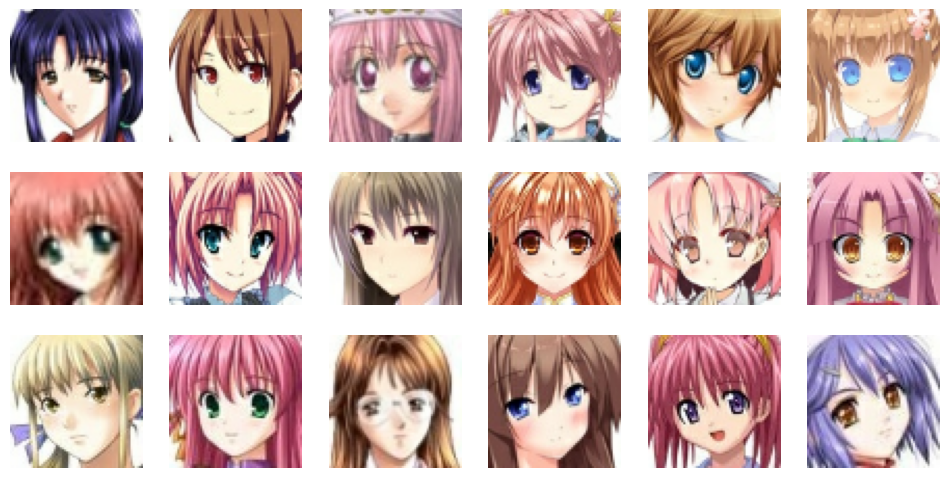

In [92]:
plt.figure(figsize=(12,6))
for images in data.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")

### Выполним нормализацию 
Каждый из трех каналов RGB на изображении может принимать значения пикселей в диапазоне от 0 до 256. Деление его на 255 преобразует его в диапазон от 0 до 1.

In [4]:
data = data.map(lambda x: x / 255.0)
data

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

## Создадим генератор 

In [88]:
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=100))  # 100- Количество точек, используемых как входной массив для генератора изображений
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         295040    
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 8, 8, 128)        

## Создадим дискриминатор

In [89]:
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 17, 17, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Bat  (None, 17, 17, 64)       256       
 chNormalization)                                     

In [8]:
#вердикт дискриминатора
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.5001578]], shape=(1, 1), dtype=float32)


По выходным данным дискриминатора видном, что около 50% вероятность того, что изображение является реальным.

### Определение класcа нейронной сети GAN

In [9]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Определяем размер батча для обучения
        batch_size = tf.shape(real_images)[0]
        # Формируем набор случайных "заготовок" для генерации изображений
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Генерируем изображения из случайного шума
        generated_images = self.generator(seed)
        # Собираем вместе сгенерированные и загруженные изображения
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Собираем метки классов: 1 для сгенерированных изображений, 0 для загруженных изображений
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Добавляем шум к сформированным меткам (это важно!!!)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Обучаем дискриминатор
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # заново формируем набор "заготовок" для генерации изображений
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # при этом формируем метки как для загруженных изоюражений (0)
        misleading_labels = tf.zeros((batch_size, 1))

        # Обучаем генератор (При этом мы не обновляем веса дискриминатора!!!)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Обновляем метрики моделей
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        # Формируем и возвращаем информацию об изменении метрик
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [10]:
epochs = 15
# Оптимизатор для дискриминатора и генератора
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)

# Функция потерь
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Создание и компиляция модели GAN
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

# Обучение модели
history = model.fit(data, epochs=epochs)

Epoch 1/15
1987/1987 [==============================] - 1048s 524ms/step - d_loss: 0.5370 - g_loss: 1.1621
Epoch 2/15
1987/1987 [==============================] - 1040s 523ms/step - d_loss: 0.4981 - g_loss: 1.2811
Epoch 3/15
1987/1987 [==============================] - 1040s 523ms/step - d_loss: 0.5236 - g_loss: 1.2806
Epoch 4/15
1987/1987 [==============================] - 1038s 522ms/step - d_loss: 0.5588 - g_loss: 1.2133
Epoch 5/15
1987/1987 [==============================] - 1041s 524ms/step - d_loss: 0.5494 - g_loss: 1.2580
Epoch 6/15
1987/1987 [==============================] - 1040s 523ms/step - d_loss: 0.5261 - g_loss: 1.3418
Epoch 7/15
1987/1987 [==============================] - 1038s 522ms/step - d_loss: 0.4865 - g_loss: 1.4689
Epoch 8/15
1987/1987 [==============================] - 1036s 521ms/step - d_loss: 0.4717 - g_loss: 1.5663
Epoch 9/15
1987/1987 [==============================] - 1039s 523ms/step - d_loss: 0.4708 - g_loss: 1.5781
Epoch 10/15
1987/1987 [==============

### Визуализация

Text(0.5, 1.0, 'Кривые функций потерь')

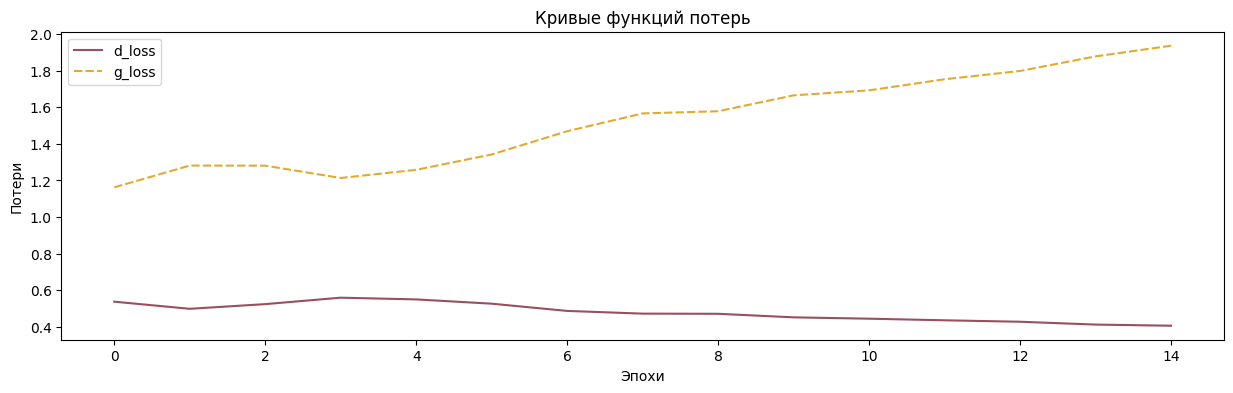

In [91]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Эпохи")
ax.set(ylabel ="Потери")
ax.set_title("Кривые функций потерь")

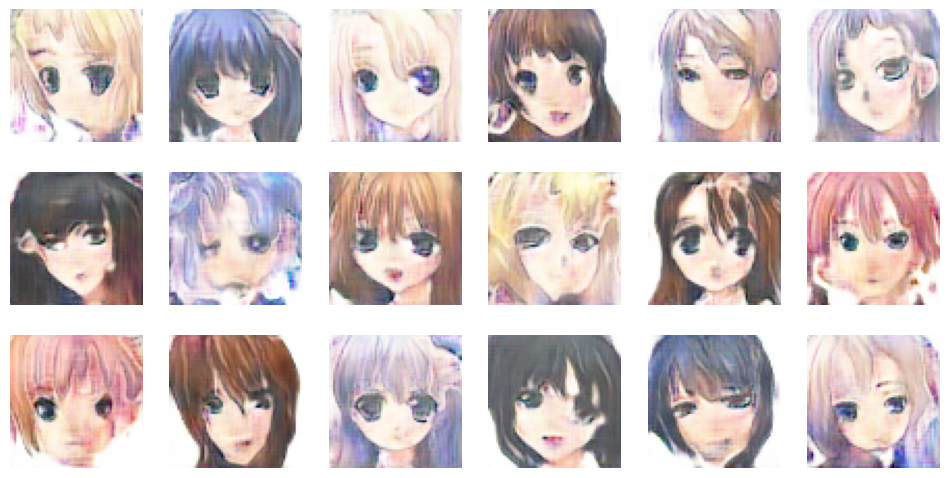

In [74]:
# Количество изображений, которые необходимо сгенерировать
num_img=18

# Функция для создания и сохранения изображений

images_list = []
seed = tf.random.normal([num_img, latent_dim])
generated_image = generator(seed)
generated_image *= 255 
generated_image = generated_image.numpy()
for i in range(num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
        images_list.append(img)
    

# Генерация изображений
plt.figure(figsize=(12, 6))
for i in range(len(images_list)):
    ax = plt.subplot(3, 6, i + 1)
    ax.imshow(images_list[i])
    ax.axis("off")